PCLab#5 - Group 2 - Emanuele Sala, Luca Soleri, Fabio Stefana

<div style="border: 4px solid #007bff; padding: 10px; background-color: #e9f5ff; border-radius: 5px;">
    <h1 style="color: #007bff;">Importing libraries and Dataset</h1>
</div>


In [64]:
import pandas as pd
import os

In [65]:
directory = "data/sigwatch_data"
df_list = []

for file in os.listdir(directory):
    if file.endswith(".dta"):
        file_path = os.path.join(directory, file)
        temp_df = pd.read_stata(file_path)
        df_list.append(temp_df)
        
df = pd.concat(df_list, ignore_index=True)

<div style="border: 4px solid #007bff; padding: 10px; background-color: #e9f5ff; border-radius: 5px;">
    <h1 style="color: #007bff;">Day 1: Preliminary data exploration</h1>
</div>

In [66]:
# With this filter we keep only the banks
df = df[df["corp_industry_sector1"] == "Finance"]

In [ ]:
# And with this filter we only keep the countries form the US, UK or EU
countries = ['Austria',
             'US',
             'Denmark',
             'UK',
             'Germany',
             'Luxembourg',
             'France',
             'Italy',
             'Netherlands',
             'Belgium',
             'Sweden',
             'Spain',
             'Ireland',
             'Portugal',
             'Poland',
             'Finland',
             'USA',
             'Croatia',
             'Bulgaria',
             'Montenegro',
             'Bosnia and Herzegovina']

df = df[df['country_corp'].isin(countries)]
df.reset_index(drop=True, inplace=True)

In [68]:
# We count the unique number of ud_archive as some have more than one row but still count as one isngle campaing
n_of_campaigns = len(list(df["uid_archive"].unique()))
print(f"There are {n_of_campaigns} unique campaigns for US UK and EU banks")

There are 2370 unique campaigns for US UK and EU banks


In [69]:
list_of_ngo_columns = []
for i in range(5):
    i = i+1
    ngo_column_number = f"ngo_name{i}"
    ngo_col = list(df[ngo_column_number])
    list_of_ngo_columns += ngo_col
unique_ngos = list(set(list_of_ngo_columns))

# we do -1 because we have to account for the null value
print(f"There are {len(unique_ngos) - 1} unique NGO organizations involved in this dataset")

There are 932 unique NGO organizations involved in this dataset


In [112]:
# Get the number of unique firms targeted
num_firms_targeted = df['company'].nunique()

print(f"Number of firms targeted: {num_firms_targeted}")


Number of firms targeted: 815


In [118]:
unique_ngos_power = df['ngo_power1'].unique()

unique_prominence = df['prominence'].unique()

unique_sentiment = df['sentiment'].unique()

print(f"Unique NGO Power values: {unique_ngos_power}")
print(f"Unique Prominence values: {unique_prominence}")
print(f"Unique Sentiment values: {unique_sentiment}")

Unique NGO Power values: [2.5  0.5  1.   1.5  2.75 2.  ]
Unique Prominence values: [3 2 4 1 0]
Unique Sentiment values: [-2 -1  2  0  1]


The variables prominence, sentiment, and ngo_power likely represent different aspects of the firms and their interactions with NGOs or external factors.

prominence: This variable measures the visibility or importance of a firm in the context of the issue being discussed from 0, least visible, to 4, highest visible. A higher number may indicate greater prominence, such as higher media attention, public scrutiny, or relevance in the specific issue or campaign.

sentiment: This variable represents the sentiment associated with the firm or the coverage of the issue it is involved in. It is scored on a scale from -2 to +2, where negative values indicate negative sentiment, positive values indicate positive sentiment, and 0 or neutral values indicate no strong sentiment.


ngo_power (ngo_power1, ngo_power2, etc.): This variable measures the perceived influence of the NGO (Non-Governmental Organization) involved in the campaign or issue. A higher number indicates greater perceived power or influence of the NGO in shaping public opinion, affecting the firm, or pushing for changes. It goes from 0 to 3.


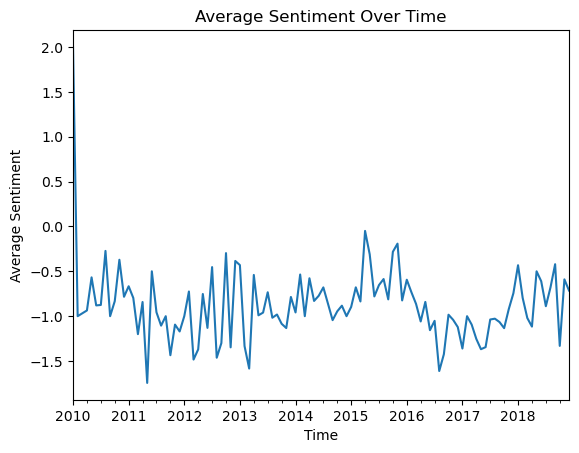

In [122]:
df['date'] = pd.to_datetime(df['date'])
sentiment_over_time = df.groupby(df['date'].dt.to_period('M'))['sentiment'].mean()
sentiment_over_time.plot()
plt.title('Average Sentiment Over Time')
plt.xlabel('Time')
plt.ylabel('Average Sentiment')
plt.show()


Over time, there is not a particular shift in terms of sentiment, which stay moderately negative from 2010 to 2019

In [ ]:
avg_sentiment_by_prominence = df.groupby('prominence')['sentiment'].mean()
print(avg_sentiment_by_prominence)

avg_sentiment_by_ngo_power = df.groupby('ngo_power1')['sentiment'].mean()
print(avg_sentiment_by_ngo_power)




prominence
0   -1.000000
1   -0.860390
2   -0.723370
3   -0.961952
4   -1.282843
Name: sentiment, dtype: float64
ngo_power1
0.50   -1.086207
1.00   -0.924983
1.50   -0.931360
2.00   -0.599237
2.50   -0.868298
2.75   -1.088889
Name: sentiment, dtype: float64


Prominence:
The prominence values are negative across the board, with scores ranging from -1.282843 to -0.723370.
These values suggest that the firms with higher prominence (less negative values) are still associated with overall negative sentiment. In this case, negative sentiment prevails across all levels of prominence, but firms with lower prominence seem to have slightly worse sentiment scores.


NGO Power (ngo_power1):
Similarly, the sentiment associated with different levels of NGO power is also predominantly negative. The sentiment scores range from -1.086207 to -0.599237.
As NGO power increases from 0.50 to 2.75, there is a slight variation in sentiment. The sentiment is least negative when ngo_power1 is at 2.00 (-0.599237), but generally, higher NGO power levels are still linked to negative sentiment, with some fluctuation around these values.



Prominent firms tend to receive negative sentiment, with no clear trend toward positive sentiment as prominence increases.
NGO power also does not seem to strongly shift sentiment in a positive direction. While there is slight variability in sentiment across different NGO power levels, the overall sentiment remains negative.
These results suggest that both prominence and NGO power are associated with negative sentiment, though the relationships are not drastically strong or linear. The sentiment might be influenced by other factors, and further exploration could help uncover more nuanced patterns.

# Reddit Analysis

Unfortunately, we couldn't scrape the relevant data from Reddit due to API cost and the fact that the free tier did not allow for date filtering, hence the code would need to run for hours before reaching the relevant point in time, and still in that scenario we had no certainty about the success of the query. There were some methods before for filtering like using the Pushshift library, but it's not working anymore. The code still works if we want to scrape for example present data.

In [86]:
import praw
import pandas as pd
from datetime import datetime, timedelta

# Reddit API credentials
client_id = "RQswmwIqjV3DmpuBke34QQ"
client_secret = "EhyqqRfPu3x4EDVnsGTMD12y0xFbBQ"
user_agent = "finance_scrape (by u/Kashiko_02)"

# Set up the Reddit client
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent
)

# Sample data from your dataset
#campaigns = [df['company'], df['ngo_name1'], df['date']]

df_1 = df.copy()
#keep only first few words of the report
df_1['report'] = df_1['report'].str[:100]

columns_to_keep = ['date', 'company', 'ngo_name1', 'ngo_name2', 'ngo_name3', 'ngo_name4', 'ngo_name5','report']
campaign = df_1.reindex(columns=columns_to_keep)
campaign = campaign.iloc[:50]


# Data collection
reddit_data = []

for index, campaign in campaign.iterrows():
    ngos = [campaign['ngo_name1'], campaign['ngo_name2'], campaign['ngo_name3'], 
        campaign['ngo_name4'], campaign['ngo_name5']]
    
    campaign_date = datetime.strptime(campaign["date"], "%Y-%m-%d")
    campaign_year = campaign_date.year

    # Filter out empty NGO names and join them with spaces
    ngos = "; ".join([ngo for ngo in ngos if ngo])
    search_query = f"{campaign['company']} {campaign['report']} {ngos}".strip()  
    #    print(search_query)
    
    
    search_limit = 100
    
    # Perform the search
    submissions = reddit.subreddit("finance").search(search_query, limit=search_limit)
    
    
    # Convert campaign date to timestamp range
    date_before = campaign_date + timedelta(days=365)
    date_after = campaign_date - timedelta(days=100)

    # Filter and collect data
    for submission in submissions:
        # Convert Reddit post date
        post_date = datetime.utcfromtimestamp(submission.created_utc)
        post_date = datetime.strptime(str(post_date), "%Y-%m-%d %H:%M:%S")
        post_date = post_date.strftime("%Y-%m-%d")
        post_date = datetime.strptime(post_date, "%Y-%m-%d")
        
        
        #print(date_after,post_date,date_before)
        
        # Check if post falls within the date range
        if date_after <= post_date <= date_before:
            reddit_data.append({
                "company": campaign["company"],
                "NGO": ngos,
                "date": campaign["date"],
                "title": submission.title,
                "text": submission.selftext,
                "created_utc": submission.created_utc,
                "url": submission.url,
            #    "subreddit": submission.subreddit.display_name
            })
            

# Save to a DataFrame
df_reddit = pd.DataFrame(reddit_data)


# The next steps would be to clean the text for sentiment analysis and apply a sentiment model.

df_reddit.to_csv("reddit_data.csv", index=False)

In [ ]:
import praw
import pandas as pd
from datetime import datetime, timedelta
import time


# Reddit API credentials
client_id = "RQswmwIqjV3DmpuBke34QQ"
client_secret = "EhyqqRfPu3x4EDVnsGTMD12y0xFbBQ"
user_agent = "finance_scrape (by u/Kashiko_02)"

# Set up the Reddit client
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent
)

# Sample data from your dataset
df_1 = df.copy()
# Keep only the first few words of the report (to limit the query size)
df_1['report'] = df_1['report'].str[:100]

columns_to_keep = ['date', 'company', 'ngo_name1', 'ngo_name2', 'ngo_name3', 'ngo_name4', 'ngo_name5', 'report']
campaign = df_1.reindex(columns=columns_to_keep)
campaign = campaign.iloc[5000:5200]


# Data collection
reddit_data = []

for index, campaign in campaign.iterrows():
    if index % 50 == 0:
        time.sleep(2)

    

    ngos = [campaign['ngo_name1'], campaign['ngo_name2'], campaign['ngo_name3'], 
            campaign['ngo_name4'], campaign['ngo_name5']]
    
    campaign_date = datetime.strptime(campaign["date"], "%Y-%m-%d")
    campaign_year = campaign_date.year

    # Filter out empty NGO names and join them with spaces
    ngos = "; ".join([ngo for ngo in ngos if ngo])
    
    # Modify the search query to focus on the NGO names and the company
    search_query = f"{campaign['company']} {ngos}".strip()  
    
    search_limit = 20  # Adjust to your needs
    
    # Perform the search (focuses on the finance subreddit)
    submissions = reddit.subreddit("finance").search(search_query, limit=search_limit)
    
    # Convert campaign date to timestamp range
    date_before = campaign_date + timedelta(days=365)
    date_after = campaign_date - timedelta(days=100)

    # Filter and collect data
    for submission in submissions:
        # Convert Reddit post date
        post_date = datetime.utcfromtimestamp(submission.created_utc)
        post_date = datetime.strptime(str(post_date), "%Y-%m-%d %H:%M:%S")
        post_date = post_date.strftime("%Y-%m-%d")
        post_date = datetime.strptime(post_date, "%Y-%m-%d")
        
        # Check if post falls within the date range
        if date_after <= post_date <= date_before:
            # Check if the NGO names are mentioned in the post's title or text
            if any(ngo.lower() in submission.title.lower() or ngo.lower() in submission.selftext.lower() for ngo in ngos.split("; ") or 'ngo' in submission.title.lower() or 'ngo' in submission.selftext.lower()):
                reddit_data.append({
                    "company": campaign["company"],
                    "NGO": ngos,
                    "date": campaign["date"],
                    "title": submission.title,
                    "text": submission.selftext,
                    "created_utc": submission.created_utc,
                    "url": submission.url,
                })
                

# Save to a DataFrame
df_reddit = pd.DataFrame(reddit_data)

# Save to a CSV file
df_reddit.to_csv("reddit_data.csv", index=False)



# Links Analysis

***Do not run it, it takes something like 300 minutes to completely run.***

This code scrapes text from URLs in a DataFrame, checks their accessibility, extracts content, and saves each row’s combined text in separate files. It starts by importing requests and BeautifulSoup for HTTP requests and HTML parsing, respectively. The is_url_accessible function verifies if a URL is reachable by checking its status code (200, 301, or 302). The get_text_from_url function follows redirects, skips non-HTML pages, and avoids error pages (e.g., with "404" in the title). It then extracts, cleans, and filters text based on a minimum length requirement. The code iterates through each row of the DataFrame, processing up to five URLs per row, and combines any extracted text. If valid text is found, it saves it to a uniquely named file for each row. This structure supports organized storage for further analysis but may face limitations with server rate limits, making it challenging for large datasets or historical data from certain sources.


In [109]:
import requests
from bs4 import BeautifulSoup

# Function to check if the URL is accessible
def is_url_accessible(url, timeout=3):
    try:
        response = requests.head(url, timeout=timeout, allow_redirects=True)  # Allow redirects
        # Check for successful status codes (200, 301, 302)
        return response.status_code in [200, 301, 302]
    except requests.RequestException as e:
        print(f"Error checking URL {url}: {e}")
        return False

# Function to fetch and parse content from the final destination URL after redirection
def get_text_from_url(url, timeout=5, min_length=2700):
    try:
        # First make the GET request with redirection allowed
        response = requests.get(url, timeout=timeout, allow_redirects=True)
        
        # Check if there is a redirect
        if response.status_code in [301, 302]:
            final_url = response.headers['Location']  # Get the final redirect URL
            response = requests.get(final_url, timeout=timeout)  # Fetch the redirected URL

        # Skip non-HTML content types
        if 'text/html' not in response.headers.get('Content-Type', ''):
            return None

        # Check if the title contains '404' or 'page is missing' to ignore these pages
        try:
            soup = BeautifulSoup(response.text, 'lxml')
            title = soup.title.string if soup.title else ""
            if "404" in title.lower() or "error" in title.lower() or "ops" in title.lower():
                return None  # Skip this page
        except Exception:
            soup = BeautifulSoup(response.text, 'html5lib')
            title = soup.title.string if soup.title else ""
            if "404" in title.lower() or "error" in title.lower() or "ops" in title.lower():
                return None  # Skip this page

        # Extract and clean up text
        unwanted_chars = [',', '\n', '\t', ';', '\\']
        extracted_text = ' '.join(
            ''.join(char for char in p.get_text() if char not in unwanted_chars)
            for p in soup.find_all('p')
        )
        
        # Only save text if it is longer than the minimum length specified
        if len(extracted_text) < min_length:
            return None
        
        return extracted_text

    except (requests.RequestException, Exception):
        return None
    
# Sample DataFrame for testing (just 20 row)
#df_filtered = df.head(20)

# Process and fetch text for links
text_data = []

total_rows = len(df)

for index, row in df.iterrows():
    print(f"Processing row {index + 1}/{total_rows}...")
    
    texts = []
    for col in ['link1', 'link2', 'link3', 'link4', 'link5']:
        url = row[col]
        if pd.notna(url):  # Check if there is a URL
            text = get_text_from_url(url)
            if text:
                texts.append(text)
    combined_text = ' '.join(texts)
    text_data.append(combined_text)

    # Optionally, save text for each row in a file or handle it as needed
    if combined_text:  # Only save if there's non-null text
        file_name = f"text_files/text_data_row_{index + 1}.txt"
        with open(file_name, "w") as file:
            file.write(combined_text)
        #print(f"Saved text for row {index + 1} to {file_name}")

print("All rows processed and saved into separate text files.")


Processing row 1/6625...


KeyboardInterrupt: 

This code detects and translates the content of text files, storing the translated text in a DataFrame. Using the langdetect library, it first checks the language of each text file, and if the content isn’t in English, it utilizes GoogleTranslator from deep_translator to translate the text to English. The detect_and_translate function handles large texts by splitting them into chunks of up to 4500 characters (to meet translation limits), translating each chunk individually, and then recombining them. For each file in a specified folder, the code extracts the row index from the filename, reads the text, detects its language, and translates it if necessary. Empty files are set to None. The processed content is then stored in the DataFrame’s text_from_links column at the appropriate row. This approach allows for efficient handling of moderately large text data, although high volumes may be limited by API rate or cost constraints.

Checking if it's in English, else we translate it

In [ ]:
from langdetect import detect
from deep_translator import GoogleTranslator

# Function to detect language and translate if necessary
def detect_and_translate(text):
    if not text:
        return None  # Handle cases with empty text
    
    try:
        # Detect language
        lang = detect(text)
        
        # If language is not English, proceed with translation
        if lang != 'en':
            # Check text length and split into smaller chunks if necessary
            max_chunk_length = 4500
            if len(text) > max_chunk_length:
                chunks = [text[i:i + max_chunk_length] for i in range(0, len(text), max_chunk_length)]
                translated_chunks = []
                
                # Translate each chunk
                for chunk in chunks:
                    translator = GoogleTranslator(source=lang, target='en')
                    translated_chunk = translator.translate(chunk)
                    translated_chunks.append(translated_chunk)
                
                # Combine translated chunks into a single string
                return ' '.join(translated_chunks)
            else:
                # If the text is within the limit, just translate it
                translator = GoogleTranslator(source=lang, target='en')
                translated_text = translator.translate(text)
                return translated_text
        else:
            return text  # Already in English, no translation needed

    except Exception as e:
        print(f"Error processing text: {e}")
        return text  # Return original text on detection failure
    
    
    


# Create a new column in the DataFrame for storing the text data
df['text_from_links'] = None

# Define the path to the folder containing the text files
folder_path = 'text_files'

# Iterate through each file in the folder
for filename in os.listdir(folder_path):
    if filename.startswith("text_data_row_") and filename.endswith(".txt"):
        # Extract the row index from the filename
        row_index = int(filename.split("_")[-1].split(".")[0]) - 1  # Adjust for 0-based index

        # Construct the full path to the file
        file_path = os.path.join(folder_path, filename)

        # Read the file content
        with open(file_path, 'r', encoding='utf-8') as file:
            text_content_raw = file.read().strip()  # Remove any leading/trailing whitespace
            #print(text_content_raw)

            # Only translate if there's actual content
            if text_content_raw:
                lang = detect(text)
                if lang != 'en':
                    text_content = detect_and_translate(text_content_raw)
                else:
                    text_content = text_content_raw
            else:
                text_content = None  # Handle empty file

        # Store the content in the corresponding row of the DataFrame
        df.at[row_index, 'text_from_links'] = text_content

print("Text content loaded into the DataFrame.")



text_data_row_3466.txt
text_data_row_4309.txt
text_data_row_5771.txt
text_data_row_3314.txt
text_data_row_3472.txt
text_data_row_1265.txt
text_data_row_6244.txt
text_data_row_5995.txt
text_data_row_3328.txt
text_data_row_6536.txt
text_data_row_2963.txt
text_data_row_6287.txt
text_data_row_295.txt
text_data_row_4484.txt
text_data_row_5942.txt
text_data_row_3664.txt
text_data_row_5215.txt
text_data_row_1067.txt
text_data_row_1701.txt
text_data_row_1729.txt
text_data_row_72.txt
text_data_row_4137.txt
text_data_row_3658.txt
text_data_row_4645.txt
text_data_row_99.txt
text_data_row_4692.txt
text_data_row_1098.txt
text_data_row_2591.txt
text_data_row_3857.txt
text_data_row_4686.txt
text_data_row_5598.txt
text_data_row_6091.txt
text_data_row_5407.txt
text_data_row_5361.txt
text_data_row_5375.txt
text_data_row_3704.txt
text_data_row_1675.txt
text_data_row_6132.txt
text_data_row_2432.txt
text_data_row_5349.txt
text_data_row_6126.txt
text_data_row_120.txt
text_data_row_1891.txt
text_data_row_473

This code performs sentiment analysis on text data from a DataFrame using the TextBlob library. The function analyze_sentiment first checks if the text is missing or empty; if so, it returns a default "neutral" sentiment with a polarity of 0. If the text exists, TextBlob calculates its polarity score, a value between -1 and 1 that indicates sentiment from negative to positive. Based on the polarity score, the code assigns a sentiment label ("positive," "neutral," or "negative") and rescales the polarity into discrete categories: 2 for strong positive (≥ 0.1), 1 for slight positive (≥ 0.01), -1 for slight negative (≤ -0.01), -2 for strong negative (≤ -0.1), and 0 for neutral.

The analyze_sentiments_with_progress function iterates through the DataFrame rows, applying analyze_sentiment to each row's text_from_links column and storing the results in lists. These lists, representing the sentiment labels and rescaled polarity scores, are then added to new columns in the original DataFrame. The tqdm library adds a progress bar to show processing progress. The final DataFrame includes columns for the sentiment labels and rescaled polarity scores derived from the text content in each row.

In [100]:
from textblob import TextBlob
from tqdm import tqdm  # For the progress bar


# Function to analyze sentiment using TextBlob
def analyze_sentiment(text):
    # Handle missing or null text
    if not text or pd.isnull(text):  # Check if text is None, NaN, or empty
        return 'neutral', 0  # Default neutral sentiment
    
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    
    if polarity >= 0.1:
        sentiment = 'positive'
        rescaled_polarity = 2
    elif polarity >= 0.01:
        sentiment = 'positive'
        rescaled_polarity = 1
    elif polarity <= -0.1:
        sentiment = 'negative'
        rescaled_polarity = -2
    elif polarity <= -0.01:
        sentiment = 'negative'
        rescaled_polarity = -1
    else:
        sentiment = 'neutral'
        rescaled_polarity = 0
    
    
    return sentiment, rescaled_polarity

# Apply sentiment analysis with progress tracking
def analyze_sentiments_with_progress(df):
    sentiments = []
    polarities = []
    
    # Add a progress bar using tqdm
    for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Rows"):
        text = row['text_from_links']
        sentiment, polarity = analyze_sentiment(text)
        sentiments.append(sentiment)
        polarities.append(polarity)
    
    # Add the results back to the DataFrame
    df['sentiment_from_links'] = sentiments
    df['polarity_from_links'] = polarities
    
    return df

# Call the function and see the results
df = analyze_sentiments_with_progress(df)

df

Processing Rows: 100%|██████████| 6625/6625 [00:20<00:00, 329.21it/s] 


,uid_archive,date,company_code,company,company_type,company_parent_code,company_parent,company_parent_country,sentiment,prominence,...,industry_sector4,report,link1,link2,link3,link4,link5,text_from_links,sentiment_from_links,polarity_from_links
0,40909,2011-12-21,3850,Bank Austria,Subsidiary,1149,UniCredit,Italy,-2,3,...,NaN,"In Austria, GLOBAL 2000 and Greenpeace activis...",http://www.global2000.at/site/de/nachrichten/a...,http://www.global2000.at/site/de/nachrichten/a...,,,NaN,None,neutral,0
1,40883,2011-12-21,49,World Bank,Parent,49,World Bank,US,-1,2,...,NaN,environmental impact assessment of the contro...,http://www.noticiasser.pe/16/12/2011/cajamarca...,https://www.rainforest-rescue.org/mailalert/80...,,,NaN,Our news reports and success stories in rainfo...,positive,1
2,40868,2011-12-19,3815,Jyske Invest International,Parent,3815,Jyske Invest International,Denmark,-1,4,...,NaN,"In Denmark, DanWatch claimed that Danish pensi...",http://www.danwatch.dk/da/artikler/danske-opsp...,,,,NaN,None,neutral,0
3,40868,2011-12-19,3816,Carnegie Asset Management,Parent,3816,Carnegie Asset Management,Denmark,-1,4,...,NaN,"In Denmark, DanWatch claimed that Danish pensi...",http://www.danwatch.dk/da/artikler/danske-opsp...,,,,NaN,None,neutral,0
4,40868,2011-12-19,3818,PenSam,Parent,3818,PenSam,Denmark,-1,4,...,NaN,"In Denmark, DanWatch claimed that Danish pensi...",http://www.danwatch.dk/da/artikler/danske-opsp...,,,,NaN,None,neutral,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6620,80469,2018-01-05,572,Danske Bank,Parent,572,Danske Bank,Denmark,-1,2,...,NaN,NORWAY - Norwegian CSR group Framtiden i Vare ...,https://www.framtiden.no/gronne-tips/fritid/bl...,,,,NaN,None,neutral,0
6621,80469,2018-01-05,2162,Nordea,Parent,2162,Nordea,Sweden,-1,2,...,NaN,NORWAY - Norwegian CSR group Framtiden i Vare ...,https://www.framtiden.no/gronne-tips/fritid/bl...,,,,NaN,None,neutral,0
6622,80469,2018-01-05,4427,Handelsbanken,Parent,4427,Handelsbanken,Sweden,1,2,...,NaN,NORWAY - Norwegian CSR group Framtiden i Vare ...,https://www.framtiden.no/gronne-tips/fritid/bl...,,,,NaN,None,neutral,0
6623,80453,2018-01-04,139,European Investment Bank EIB,Parent,139,European Investment Bank EIB,Luxembourg,-2,2,...,NaN,of national laws and international financial ...,https://bankwatch.org/press_release/european-f...,https://bankwatch.org/publication/broken-river...,,,NaN,Bankwatch 20 December 2017 The intake of the T...,positive,1


This code generates two visualizations to compare the sentiment of the original reports (from the sentiment column in the DataFrame) with the sentiment calculated from scraped text (in the polarity_from_links column). The first visualization, a Sentiment Distribution Comparison (KDE Plot), uses kernel density estimation (KDE) to show the distribution of sentiment scores for both sources, providing smoothed curves to indicate where the majority of sentiment scores fall. The second visualization, a Sentiment Range Comparison (Box Plot), displays the ranges and distributions of sentiment scores, using a reshaped DataFrame and box plot to show the median, interquartile range, and any outliers for each sentiment source. Together, these visualizations allow you to compare the overall distribution (KDE plot) and range (box plot) of the original and scraped sentiment scores, helping you assess similarities or differences in sentiment trends between the two sources.

/var/folders/d7/2bcv4v4544lcyzyb61mj51zm0000gn/T/ipykernel_923/187463720.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['sentiment'], shade=True, color='blue', label='Original Sentiment')
/var/folders/d7/2bcv4v4544lcyzyb61mj51zm0000gn/T/ipykernel_923/187463720.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['polarity_from_links'], shade=True, color='orange', label='Scraped Sentiment')


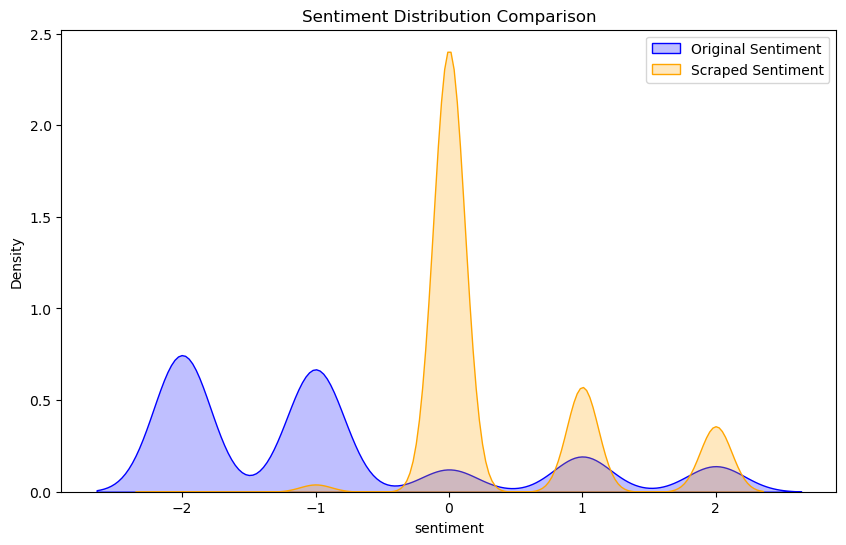

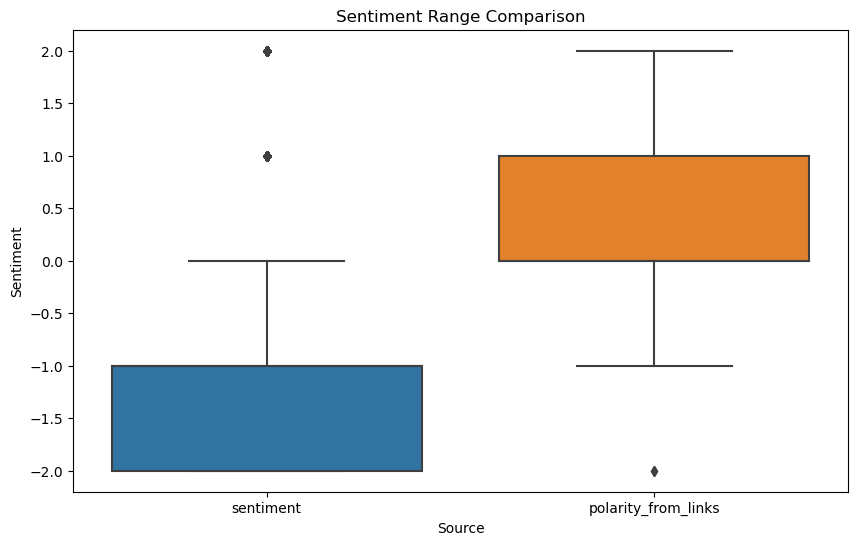

In [ ]:
##Compare the sentiment of the reports with the sentiment in the dataframe
import matplotlib.pyplot as plt
import seaborn as sns


# Distribution plot for both sentiment scores
plt.figure(figsize=(10, 6))
sns.kdeplot(df['sentiment'], shade=True, color='blue', label='Original Sentiment')
sns.kdeplot(df['polarity_from_links'], shade=True, color='orange', label='Scraped Sentiment')
plt.legend()
plt.title('Sentiment Distribution Comparison')
plt.show()

# Box plot to compare sentiment ranges
df_melted = df.melt(value_vars=['sentiment', 'polarity_from_links'], var_name='Source', value_name='Sentiment')
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, x='Source', y='Sentiment')
plt.title('Sentiment Range Comparison')
plt.show()


The sentiment given in the dataset is really negative, while the polarity we obtained from the links is mostly neutral, and instead we see a prevalence of positive sentiment around the reports, which is kind of counterintuitive, and this could be because of the reasons stated in the paragraph below.

We can see how, in the end, it was not worth it to scrape the data from the link to perform the sentiment analysis, that is for several reasons:

1) We ended up missing on a lot of the data, maybe because links were not available anymore, or because they needed an ad-hoc scraper (think of having to accept cookies, being re-directed to another link, being re-directed to the landing page), which was something challenging to work around, and we didn't manage to fix all of the scenarios, so we ended up with 1992 items out of 6625

2) The model used for sentiment analysis was the best considering also the time needed, but given the fact that the majority of texts were really long, the best approach would have been to use  LLMs, dividing each text into right size chunks, feed them to the llm, and then averaging the score of that specific text. But this required a high-performing machine, and given also the volume of the data to analyze, it needed also a lot of time to run it, and in the end we understood it was not feasible. The model we used offers the best trade-off between quality and time, although for these kind of texts, it doesn't perform really well, in fact, before standardizing the polarity score, it was centered around 0, and the performance could have been similar to putting random values as sentiment, so the analysis in the end from the link is not satisfactory.